## Bayesian Calibration: Falling Ball

To illustrate how to use XXX within YYY we will start with a very simple example of a falling ball example. 

First, import the main libraries we use for this example.

In [1]:
import numpy as np
import scipy.stats as sps
import sys
import os
import copy

### Data: Falling Ball 

This data include ... We collect the data at two different heights 25 and 50. SOME STORY AND THE REFERENCE TO DATA. EXPLAIN WHAT THETA IS...

In [2]:
x = np.array([[ 0.1, 25. ],
              [ 0.2, 25. ],
              [ 0.3, 25. ],
              [ 0.4, 25. ],
              [ 0.5, 25. ],
              [ 0.6, 25. ],
              [ 0.7, 25. ],
              [ 0.9, 25. ],
              [ 1.1, 25. ],
              [ 1.3, 25. ],
              [ 2.0, 25. ],
              [ 2.4, 25. ],
              [ 0.1, 50. ],
              [ 0.2, 50. ],
              [ 0.3, 50. ],
              [ 0.4, 50. ],
              [ 0.5, 50. ],
              [ 0.6, 50. ],
              [ 0.7, 50. ],
              [ 0.8, 50. ],
              [ 0.9, 50. ],
              [ 1.0, 50. ],
              [ 1.2, 50. ],
              [ 3.5, 50. ],
              [ 3.7, 50. ],
              [ 2.6, 50. ],
              [ 2.9, 50. ],
              [ 3.1, 50. ],
              [ 3.3, 50. ],]).astype('object')

Let's check the number of observations and the columns first.

In [3]:
print(np.shape(x))

(29, 2)


What does physics say? ADD FORMULAS FOR THE TRUE FORMULA

In [4]:
def balldroptrue(x):
    """Place description here."""
    def logcosh(x):
        # preventing crashing
        s = np.sign(x) * x
        p = np.exp(-2 * s)
        return s + np.log1p(p) - np.log(2)
    t = x[:, 0]
    h0 = x[:, 1]
    vter = 20
    g = 9.81
    y = h0 - (vter ** 2) / g * logcosh(g * t / vter)
    return y

In [5]:
xv = x.astype('float')

# variance for the observations in 'y' below
obsvar = 4*np.ones(x.shape[0])  

#observations at each row of 'x'
y = balldroptrue(xv) + sps.norm.rvs(0, np.sqrt(obsvar)) 

print(np.shape(y))

(29,)


Let's replace the height of 25 and 50 in the second column with 'lowdrop' and 'highdrop', respectively:

In [6]:
x[x[:,1] == 25, 1] = 'lowdrop'
x[x[:,1] == 50, 1] = 'highdrop'

### Computer model experiments

ADD FORMULAS AND SOME STORY

In [7]:
def balldropmodel_linear(x, theta):
    """Place description here."""
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1] + theta[k, 0]
        vter = theta[k, 1]
        f[k, :] = h0 - vter * t
    return f.T

In [8]:
def balldropmodel_grav(x, theta):
    """Place description here."""
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

Next, we consider the computer model implementation of our mathematical model on a testing grid $t \in [0.1, 4.2]$ and $h \in \{25, 50\}$. First, we generate ...

In [9]:
# the time vector of interest
tvec = np.concatenate((np.arange(0.1, 4.3, 0.1), np.arange(0.1, 4.3, 0.1))) 

# the drop heights vector of interest
hvec = np.concatenate((25 * np.ones(42), 50 * np.ones(42)))  

# the input of interest
xtot = (np.vstack((tvec, hvec)).T).astype('object')  
xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

In [10]:
print(np.shape(xtot))

(84, 2)


MENTION ABOUT THE PRIORS

In [11]:
class priorphys_lin:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.norm.logpdf(theta[:, 0], 0, 5) +  # initial height deviation
                          sps.gamma.logpdf(theta[:, 1], 2, 0, 10))   # terminal velocity

    def rnd(n):
        return np.vstack((sps.norm.rvs(0, 5, size=n),  # initial height deviation
                          sps.gamma.rvs(2, 0, 10, size=n))).T  # terminal velocity


In [12]:
class priorphys_grav:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.gamma.logpdf(theta, 2, 0, 5))  # gravity

    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 5, size=n), (-1,1))  # gravity

In [13]:
# draw 50 random parameters from the prior
thetacompexp_lin = priorphys_lin.rnd(50)  
print(np.shape(thetacompexp_lin))

# the value of the linear simulation
linear_results = balldropmodel_linear(xtotv, thetacompexp_lin) 
print(np.shape(linear_results))

(50, 2)
(84, 50)


In [14]:
# draw 20 random parameters from the prior
thetacompexp_grav = priorphys_grav.rnd(20) 
print(np.shape(thetacompexp_grav))

# the value of the gravity simulation
grav_results = balldropmodel_grav(xtotv, thetacompexp_grav)  
print(np.shape(grav_results))

(20, 1)
(84, 20)


### Building an emulator via XXX

In this section, we build two emulators for XXX and YYY. Before building an emulator, we should import the required .. first.

In [25]:
#SCRIPT_DIR = os.getcwd()
#sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, '..')))
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
#sys.path.append(os.path.dirname(current))
from base.emulation import emulator

Build an emulator for the linear simulation:

In [26]:
emu_lin = emulator(xtot, thetacompexp_lin, linear_results, method = 'PCGPwM') 

Build an emulator for the gravity simulation:

In [27]:
emu_grav = emulator(xtot, thetacompexp_grav, grav_results, method = 'PCGPwM')  

### Calibration via XXX

In [28]:
from base.calibration import calibrator

In [29]:
#ask matt what they do
class priorstatdisc_model:
    def lpdf(phi):
        return np.squeeze(sps.norm.logpdf(phi[:,0], 2, 2) +
                          sps.norm.logpdf(phi[:,1], 0, 2))
    def rnd(n):
        return np.vstack((sps.norm.rvs(2, 2, size = n ),
                         sps.norm.rvs(0, 2, size = n))).T
def cov_delta(x,phi):
    xv = x[:,0].astype(float)
    C0 = np.exp(-1/2*np.abs(np.subtract.outer(np.sqrt(xv),np.sqrt(xv)))) *\
        (1+1/2*np.abs(np.subtract.outer(np.sqrt(xv),np.sqrt(xv))))
    adj = 20 / (1+np.exp(phi[1]*(xv - phi[0])))
    return (np.diag(adj) @ C0 @ np.diag(adj))

Build a calibrator for the linear model:

In [30]:
cal_lin = calibrator(emu_lin, y, x, 
                     thetaprior = priorphys_lin,
                     method = 'BDM',
                     yvar = obsvar,
                     args = {'cov_disc': cov_delta,
                             'phiprior': priorstatdisc_model})

Build a calibrator for the gravity model:

In [31]:
cal_grav = calibrator(emu_grav, y, x, 
                      thetaprior = priorphys_grav,
                      method = 'BDM',
                      yvar = obsvar,
                      args = {'cov_disc': cov_delta,
                              'phiprior': priorstatdisc_model}) 

### Obtain predictions

In [32]:
pred_lin = cal_lin.predict(xtot)

In [33]:
pred_grav = cal_grav.predict(xtot) 

### Visualize the calibration results

Text(0.5, 1.0, 'histogram for gravity')

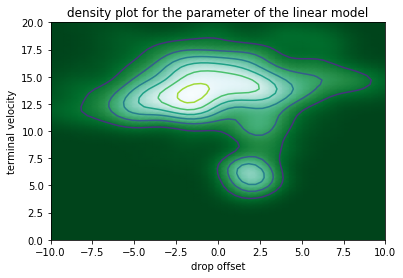

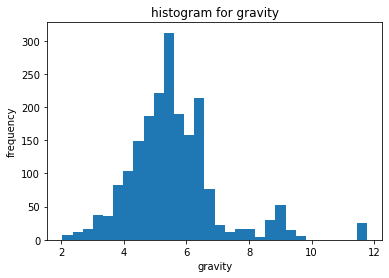

In [34]:
#We might need some universal plotting four our own software
import matplotlib.pyplot as plt 
from scipy.stats import kde
def two2d(axis, theta):
    nbins = 50
    k = kde.gaussian_kde(theta.T)
    xi, yi = np.mgrid[-10:10:nbins*1j, 0:20:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    axis.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
    axis.contour(xi, yi, zi.reshape(xi.shape))

fig1, ax1 = plt.subplots()
two2d(ax1, cal_lin.theta(2000))
ax1.set_xlabel('drop offset')
ax1.set_ylabel('terminal velocity')
ax1.set_title('density plot for the parameter of the linear model')

fig2, ax2 = plt.subplots()
ax2.hist(cal_grav.theta(2000), bins=30)
ax2.set_xlabel('gravity')
ax2.set_ylabel('frequency')
ax2.set_title('histogram for gravity')

Text(0.5, 1.0, 'prediction using gravity model')

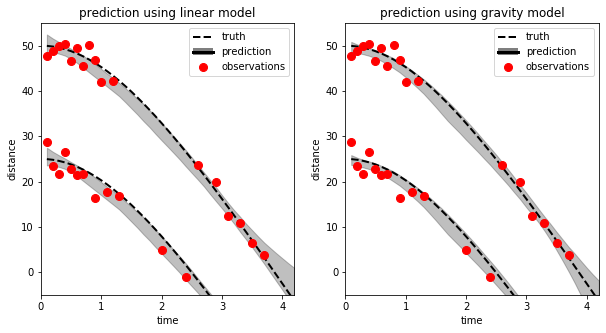

In [35]:
def plotpreds(axis, pred):
    preds = pred.rnd(1000)
    for k in (25,50):
        inds = np.where(xtotv[:,1] == k)[0]
        for l in range(0,1000):
            axis.plot(xtotv[inds,0],preds[l, inds],'k-', alpha=0.01,linewidth=0.1)
        uppercurve = np.quantile(preds[:, inds],0.975,0)
        lowercurve = np.quantile(preds[:, inds],0.025,0)
        p4 = axis.plot(xtotv[inds,0], balldroptrue(xtotv[inds,:]), 'k--',linewidth=2)
        axis.fill_between(xtotv[inds,0], lowercurve, uppercurve, color='k', alpha=0.25)
    p1 = axis.plot(np.NaN, np.NaN, color='k', linewidth=3)
    p2 = axis.fill(np.NaN, np.NaN, 'k', alpha=0.5)
    p3 = axis.plot(xv,y, 'ro' ,markersize = 8)
    axis.set_xlim([0,4.2])
    axis.set_ylim([-5,55])
    axis.set_xlabel('time')
    axis.set_ylabel('distance')
    axis.legend([p4[0],(p2[0], p1[0]), p3[0]], ['truth','prediction','observations'])
    
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
plotpreds(axes[0], pred_lin)
axes[0].set_title('prediction using linear model')
plotpreds(axes[1], pred_grav)
axes[1].set_title('prediction using gravity model')